In [1]:
#importing some useful packages

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
%matplotlib inline
from PIL import Image
import keras
import math
import random
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam, RMSprop
from scipy.misc.pilutil import imresize
"""
Steering angle prediction model
"""
import os
import argparse
import json
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, MaxPooling2D
from keras.layers.convolutional import Convolution2D


Using TensorFlow backend.


In [2]:
import pandas as pd
data = pd.read_csv('driving_log.csv', header = None)
data.columns = ["center_images","left_images","right_images","steering","brake","throttle","speed"]
len(data)

8036

In [3]:
Y_train = np.copy(data['steering'])  


In [4]:
X_train = np.copy(data['center_images']+':'+data['left_images']+':'+data['right_images'])


In [5]:
len(X_train)

8036

This image is: <class 'numpy.ndarray'> with dimesions: (160, 320, 3)


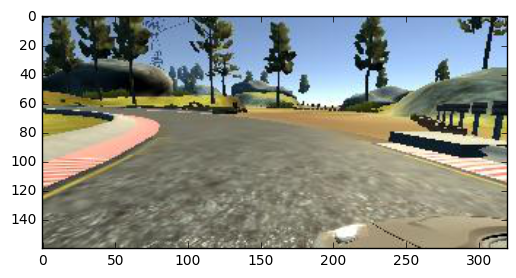

In [6]:
#reading in an image
image = mpimg.imread('IMG/left_2016_12_01_13_31_13_584.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image)  

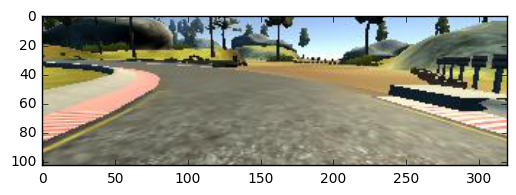

In [7]:
oriimage = mpimg.imread('IMG/left_2016_12_01_13_31_13_584.jpg', 1)
#crop face before resize
crop_face = oriimage[32:135, :]
# do any preprocessing... resize, reshape, etc. here
#newimage = cv2.resize(crop_face, (200, 66))
# crop 20% from bottom to remove car hood and 25 pixels from top
 
plt.imshow(crop_face)

In [8]:
crop_face.shape

(103, 320, 3)

In [9]:
#Resize to image to half or 65% of cropped image
newimage = imresize(crop_face, .65, interp='bilinear', mode=None)
newimage.shape

(66, 208, 3)

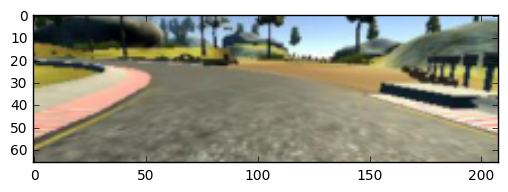

In [10]:
plt.imshow(newimage)

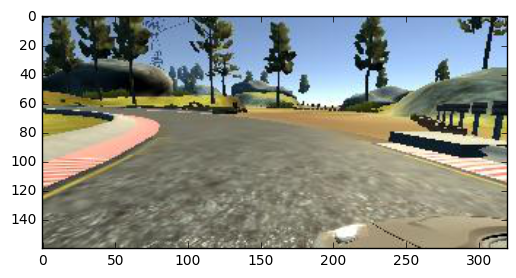

In [11]:
oriimage = mpimg.imread('IMG/left_2016_12_01_13_31_13_584.jpg', 1)
plt.imshow(oriimage)

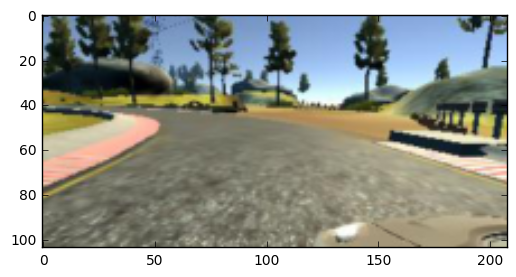

In [12]:
newimage2 = imresize(oriimage, .65, interp='bilinear', mode=None)
plt.imshow(newimage2)

In [13]:
type(newimage2[0][0][0])

numpy.uint8

In [14]:
def load_image(imagepath):
    
    oriimage = mpimg.imread(imagepath, 1)
    #crop face before resize
    #Remove 20% from the bottom to eliminate the car hood
    # 25 pixels from the top to concentrate on the road
    crop_face = oriimage[32:135, :]
    #Resize to image to half or 50% of cropped image
    newimage = imresize(crop_face, .65, interp='bilinear', mode=None)
    return newimage

In [15]:
newimage2.shape

(104, 208, 3)

In [16]:
def flip_image(image):
    flipimage = np.fliplr(image)
    return flipimage

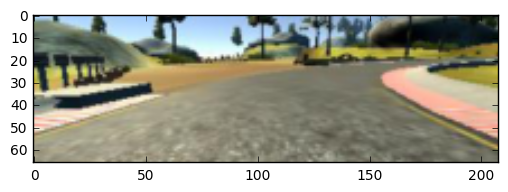

In [17]:
flipimage = np.fliplr(newimage)
plt.imshow(flipimage)

In [18]:
ind = data['throttle']>.25
data = data[ind].reset_index()

In [19]:
nb_epoch = 4
number_of_rows = 8032
image_rows = 66
image_columns = 208
image_channels = 3
batch_images = np.zeros((number_of_rows, image_rows, image_columns, image_channels))
batch_steering = np.zeros(number_of_rows)

In [20]:
#Formula is (image_size - (filter_size+1))/stride, for valid padding.

In [21]:
def remove_low_steering_angles(x,y): 
    image = []
    steer_angle = []
    for xi, yi in zip(x, y):
        probability = random.random()
        if (probability > 0.75 or abs(yi) > 0.01):
            image.append(xi)
            steer_angle.append(yi)

    image = np.array(image)
    steer_angle = np.array(steer_angle)
    return image, steer_angle

In [22]:
x_train_less, y_train_less = remove_low_steering_angles(X_train,Y_train)

In [23]:
hist, bins = np.histogram(y_train_less, bins=np.arange(10), density=True)

(array([  6.00000000e+00,   7.00000000e+00,   1.01000000e+02,
          3.94000000e+02,   5.76700000e+03,   1.40500000e+03,
          3.04000000e+02,   4.40000000e+01,   6.00000000e+00,
          2.00000000e+00]),
 array([-0.9426954 , -0.74842586, -0.55415632, -0.35988678, -0.16561724,
         0.0286523 ,  0.22292184,  0.41719138,  0.61146092,  0.80573046,  1.        ]),
 <a list of 10 Patch objects>)

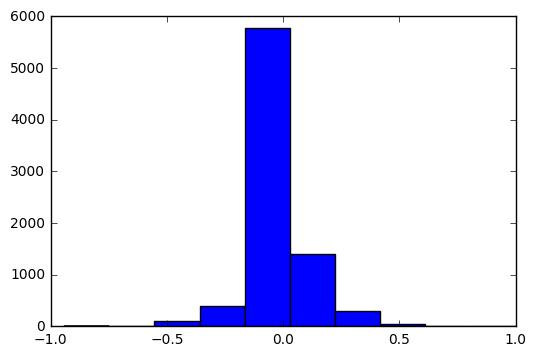

In [24]:
plt.hist(Y_train, bins=10)

In [25]:
def batchgen(X, Y):
    steer_offset = 0.25
    steer_angle = []
    counter = -1
    while counter < len(X): 
        if counter==len(X):
            counter  = 0
        for counter in range(len(X)):             
            y = Y[counter]
            if y <  0.01:
                chance = random.random()
                if chance > 0.75:
                    imagepath = X[counter].split(':')[1]
                    y = y*3
                else:
                    if chance > 0.5:
                        imagepath = X[counter].split(':')[1]
                        y = y * 1.5
                    else:
                        if chance > 0.25:
                            imagepath = X[counter].split(':')[0]
                            y = y
                        else:
                            imagepath = X[counter].split(':')[0]
                            
            elif y > 0.01:
                chance = random.random()
                if chance > 0.75:
                    imagepath = X[counter].split(':')[2]
                    y = y *3     
                else:
                    if chance > 0.5:
                        imagepath = X[counter].split(':')[2]
                        y = y * 1.5
                    else:
                        if chance > 0.25:
                            imagepath = X[counter].split(':')[0] 
                            y = y
                        else:
                            imagepath = X[counter].split(':')[0]
                     
                                    
            else:
                imagepath = X[counter].split(':')[0]
                  
            image = load_image(imagepath)
            y = np.array([[y]])
                
            if np.random.choice([True, False]):
                image = flip_image(image)
                y = -y
            image = image.astype(np.uint8)
            image = image.reshape(1, image_rows, image_columns, image_channels)
            steer_angle = np.append(steer_angle,y)
            steer_angle = np.array(steer_angle)
            yield image, y  
            
        
      

In [26]:
#st_ang = batchgen(x_train_less, y_train_less)

In [27]:
#hist, bins = np.histogram(st_ang, bins=np.arange(10), density=True)

In [28]:
#plt.hist(st_ang, bins=10)

In [29]:
def get_model():

    input_shape = (image_rows, image_columns, image_channels)
    model = Sequential()
    model.add(Lambda(lambda x: x/127.5-1 ,input_shape=input_shape))
    model.add(Convolution2D(24,5,5, subsample = (2,2),
                        border_mode='same',
                        name='conv1', init='he_normal'))
    model.add(ELU())

    model.add(Convolution2D(36,5,5, subsample = (2,2),
                        border_mode='same',
                        name='conv2', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(48,5,5, subsample = (2,2),
                        border_mode='same',
                        name='conv3', init='he_normal'))
    model.add(ELU())
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(Convolution2D(64,3,3, subsample = (1,1),
                        border_mode='same',
                        name='conv4', init='he_normal'))
    model.add(ELU())
    model.add(Convolution2D(64,3,3, subsample = (1,1),
                        border_mode='same',
                        name='conv5', init='he_normal'))
    model.add(ELU())
    
    #model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(512,name='hidden1', init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(64,name='hidden2', init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(16,name='hidden3',init='he_normal'))
    model.add(ELU())
    model.add(Dropout(0.5))
    model.add(Dense(1, name='output', init='he_normal'))
    adam = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=adam, loss='mse')
    return model

In [30]:
model = get_model()

In [31]:
samples_per_epoch = len(x_train_less)

In [32]:
max_q_size = 32

In [33]:
history = model.fit_generator(batchgen(x_train_less, y_train_less), samples_per_epoch = samples_per_epoch, nb_epoch = nb_epoch,
                    verbose=1, max_q_size = max_q_size, callbacks=[], validation_data=None, class_weight=None,
                     pickle_safe=False)

Epoch 1/4
4679/4679 [==============================] - 113s - loss: 0.0997   
Epoch 2/4
4679/4679 [==============================] - 108s - loss: 0.0953   
Epoch 3/4
4679/4679 [==============================] - 109s - loss: 0.0940   
Epoch 4/4
4679/4679 [==============================] - 108s - loss: 0.0934   


In [34]:
model.predict_generator(batchgen(x_train_less, y_train_less), 20, max_q_size=10, nb_worker=1, pickle_safe=False)

array([[-0.20723237],
       [-0.04850104],
       [ 0.08555514],
       [-0.04348531],
       [ 0.06340115],
       [-0.06910474],
       [ 0.05557808],
       [-0.06104935],
       [-0.05586467],
       [ 0.04344956],
       [ 0.02627155],
       [ 0.14302844],
       [ 0.00850767],
       [ 0.14156713],
       [ 0.13914606],
       [-0.0710868 ],
       [-0.11528838],
       [ 0.03702849],
       [-0.01923225],
       [-0.00391226]], dtype=float32)

In [35]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 208, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 33, 104, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 33, 104, 24)   0           conv1[0][0]                      
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 17, 52, 36)    21636       elu_1[0][0]                      
___________________________________________________________________________________________

In [36]:


model.save_weights("model.h5", True)
with open('model.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)
    
print("Saved model weights and configuration file.")

Saved model weights and configuration file.
